In [1]:
!python -m pip install hdf5plugin
!pip install --upgrade Pylians==0.10  # 0.10 is necessary, 0.11 will give error.

import h5py
import hdf5plugin
import gzip

In [2]:
import os
import numpy as np
import readgadget
import MAS_library as MASL
import readfof

import matplotlib.pyplot as plt

In [3]:
!ls /home/jovyan/Data/Halos/

FoF  FoF_id  Rockstar


In [4]:
!pwd
!wget https://github.com/franciscovillaescusa/Quijote-simulations/blob/master/latin_hypercube/latin_hypercube_params.txt?raw=true

/home/jovyan
--2023-11-20 06:31:36--  https://github.com/franciscovillaescusa/Quijote-simulations/blob/master/latin_hypercube/latin_hypercube_params.txt?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/franciscovillaescusa/Quijote-simulations/raw/master/latin_hypercube/latin_hypercube_params.txt [following]
--2023-11-20 06:31:36--  https://github.com/franciscovillaescusa/Quijote-simulations/raw/master/latin_hypercube/latin_hypercube_params.txt
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/franciscovillaescusa/Quijote-simulations/master/latin_hypercube/latin_hypercube_params.txt [following]
--2023-11-20 06:31:36--  https://raw.githubusercontent.com/franciscovillaescusa/Quijote-simulations/master/latin_hypercube/latin_hypercube_params.txt

In [5]:
lh_params = np.loadtxt('latin_hypercube_params.txt?raw=true')
lh_params

array([[0.1755 , 0.06681, 0.7737 , 0.8849 , 0.6641 ],
       [0.2139 , 0.05557, 0.8599 , 0.9785 , 0.8619 ],
       [0.1867 , 0.04503, 0.6189 , 0.8307 , 0.7187 ],
       ...,
       [0.1611 , 0.03709, 0.8161 , 1.0743 , 0.9983 ],
       [0.4017 , 0.04425, 0.8509 , 0.8251 , 0.7833 ],
       [0.2953 , 0.04701, 0.8017 , 0.8193 , 0.6627 ]])

In [6]:
# CONSTANTS
NUM_SIMS = 1000  # Can be any integer <= 2000.
BASE_PATH = '/home/jovyan/Data/Halos/FoF/latin_hypercube/'
OUTPUT_DIR = '/home/jovyan/my_outputs_halo/'

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

grid     = 64    #the density field will have grid^3 voxels
MAS      = 'CIC'  #Mass-assignment scheme:'NGP', 'CIC', 'TSC', 'PCS'
verbose  = True   #whether to print information about the progress
ptype    = [1]    #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

In [7]:
bad_flags = []  # For storing simulation numbers having empty voxels in the density field.

for i in range(NUM_SIMS):
    snapdir = f'/home/jovyan/Data/Halos/FoF/latin_hypercube/{i}' #folder hosting the catalogue
#     snapnum = 4                                      #number of the catalog (4-->z=0, 3-->z=0.5, 2-->z=1, 1-->z=2, 0-->z=3)

    cosmo_params = lh_params[i]  # For halos, we do not load the parameters from Cosmo_params.dat (as in density field construction) because there is no such file for Halos. So we load all parameters at once from the text file.

#     header   = readgadget.header(snapshot)
#     BoxSize  = header.boxsize/1e3  #Mpc/h
#     redshift = header.redshift     #redshift of the snapshot
#     Masses   = header.massarr*1e10 #Masses of the particles in Msun/h

    # We are hardcoding these values since it's not possible to access both the Snapshots and the Halo catalogs
    # from either the San Diego or New York cluster for the latin hypercube data.
    # TODO: I have asked Quijote simulations creators if this is the right thing to do. Until then, I don't see any problems.
    redshift = 2.220446049250313e-16
    BoxSize = 1000.0

    # read the halo catalogue
    FoF = readfof.FoF_catalog(snapdir, snapnum=4, long_ids=False,  # 4 means z=0.
                              swap=False, SFR=False, read_IDs=False)

    # get the properties of the halos
    pos_h  = FoF.GroupPos/1e3            #Halo positions in Mpc/h
    vel_h  = FoF.GroupVel*(1.0+redshift) #Halo peculiar velocities in km/s
    mass_h = FoF.GroupMass*1e10          #Halo masses in Msun/h
    Np_h   = FoF.GroupLen                #Number of CDM particles in the halo. Even in simulations with massive neutrinos, this will be just the number of CDM particles

    delta = np.zeros((grid,grid,grid), dtype=np.float32)

    # Construct 3D halo distribution
    MASL.MA(pos_h, delta, BoxSize, MAS, verbose=verbose)

    # We want the effective no. of particles in each voxel, so skip the below code.
#     delta *= Masses[1]

    if np.any(delta == 0.0):
        print('Halo distribution on the grid contains at least one empty voxel!')
        bad_flags.append(1)
    else:
        bad_flags.append(0)

    filename = os.path.join(OUTPUT_DIR, f'halos_sim{i}_LH_z0_grid{grid}_mas{MAS}.h5')
    h5f = h5py.File(filename, 'w')
    dataset = h5f.create_dataset('3D_halo_distribution', data=delta, compression='gzip')
    dataset.attrs['cosmo_params'] = cosmo_params  # Order of storing parameters is same as Cosmo_params.dat
    h5f.close()


Using CIC mass assignment scheme
Time taken = 0.009 seconds

Halo distribution on the grid contains at least one empty voxel!

Using CIC mass assignment scheme
Time taken = 0.014 seconds

Halo distribution on the grid contains at least one empty voxel!

Using CIC mass assignment scheme
Time taken = 0.009 seconds

Halo distribution on the grid contains at least one empty voxel!

Using CIC mass assignment scheme
Time taken = 0.013 seconds

Halo distribution on the grid contains at least one empty voxel!

Using CIC mass assignment scheme
Time taken = 0.012 seconds

Halo distribution on the grid contains at least one empty voxel!

Using CIC mass assignment scheme
Time taken = 0.016 seconds

Halo distribution on the grid contains at least one empty voxel!

Using CIC mass assignment scheme
Time taken = 0.012 seconds

Halo distribution on the grid contains at least one empty voxel!

Using CIC mass assignment scheme
Time taken = 0.010 seconds

Halo distribution on the grid contains at least o

In [8]:
!tar -czf halo_maps_3D_LH_z0_grid64_masCIC.tar.gz my_outputs_halo

In [9]:
!ls -lh halo_maps_3D_LH_z0_grid64_masCIC.tar.gz

-rw-r--r-- 1 jovyan jovyan 890M Nov 20 06:40 halo_maps_3D_LH_z0_grid64_masCIC.tar.gz


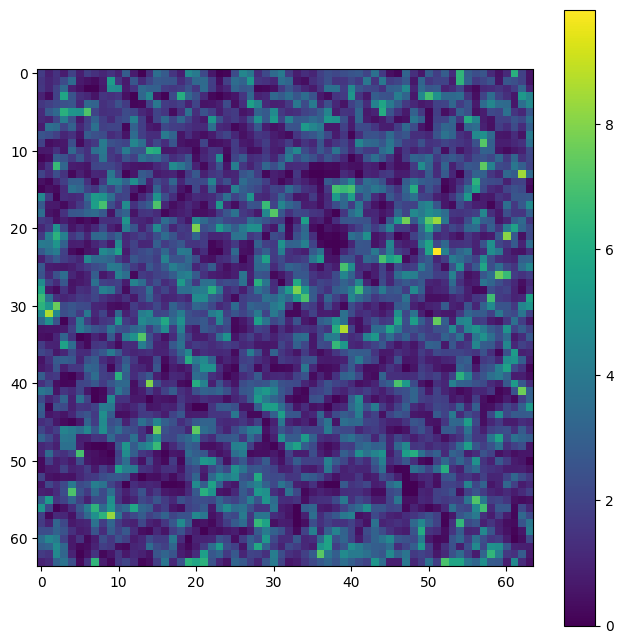

In [10]:
plt.figure(figsize=(8, 8)); plt.imshow(delta[:,:,0]); plt.colorbar()

In [11]:
print(np.any(bad_flags == 1))

False
